<a href="https://colab.research.google.com/github/sjbriggsdev/cd_finalproject/blob/master/Final_Project_Predict_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Predict Heart Disease
- Steven Briggs
- 03/25/22

## IMPORTS

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, recall_score, precision_score,ConfusionMatrixDisplay
from sklearn import set_config
set_config(display='diagram')

In [3]:
df=pd.read_csv('/content/drive/MyDrive/DATA/chddata.csv')
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


## DATA PREP AND CLEANUP

In [4]:
# using this command to compare to Data Dictionary dtypes.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


---

First attempt to convert Na_to_K Column failed because of a string so I replaced that string with a number and tried again.

---

In [5]:
# Checking for null values shows Age and BP Columns with missing
df.isna().sum()

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

In [6]:
# Checking for duplicated rows, found none.
df[df.duplicated()]

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd


---

The function below looks for unique values in each column

---

In [7]:
for col in df:
  isunique = df[col].unique()
  isunique.sort()
  print(f'- {col}:')
  print(isunique)

- sbp:
[101 102 103 106 108 109 110 112 114 116 117 118 120 121 122 123 124 126
 127 128 129 130 132 134 136 137 138 140 142 143 144 145 146 148 150 152
 153 154 156 158 160 161 162 164 166 168 170 174 176 178 180 182 188 190
 194 198 200 206 208 214 216 218]
- tobacco:
[0.000e+00 1.000e-02 2.000e-02 3.000e-02 4.000e-02 5.000e-02 6.000e-02
 7.000e-02 8.000e-02 9.000e-02 1.000e-01 1.200e-01 1.600e-01 1.800e-01
 2.100e-01 2.800e-01 3.000e-01 3.100e-01 4.000e-01 4.100e-01 4.200e-01
 4.500e-01 4.600e-01 4.800e-01 5.000e-01 5.200e-01 5.400e-01 5.600e-01
 5.700e-01 6.000e-01 6.100e-01 6.400e-01 7.000e-01 7.200e-01 7.300e-01
 7.500e-01 7.600e-01 8.000e-01 8.100e-01 8.700e-01 9.000e-01 9.200e-01
 9.500e-01 9.600e-01 1.000e+00 1.020e+00 1.030e+00 1.040e+00 1.050e+00
 1.080e+00 1.100e+00 1.150e+00 1.160e+00 1.200e+00 1.220e+00 1.250e+00
 1.320e+00 1.350e+00 1.360e+00 1.400e+00 1.440e+00 1.500e+00 1.520e+00
 1.530e+00 1.600e+00 1.610e+00 1.620e+00 1.680e+00 1.700e+00 1.720e+00
 1.750e+00 1.800e+0

---

Looking at the object columns, I found famhist has two entries "Absent" or "Present" so I set them to numeric.

---

In [8]:
df['famhist'].replace({"Absent": 0,"Present": 1}, inplace=True)

In [9]:
# Checking the DF after changes
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [10]:
# Checking the object types after changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    int64  
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 36.2 KB


In [11]:
df.describe()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


## VISUALIZATION

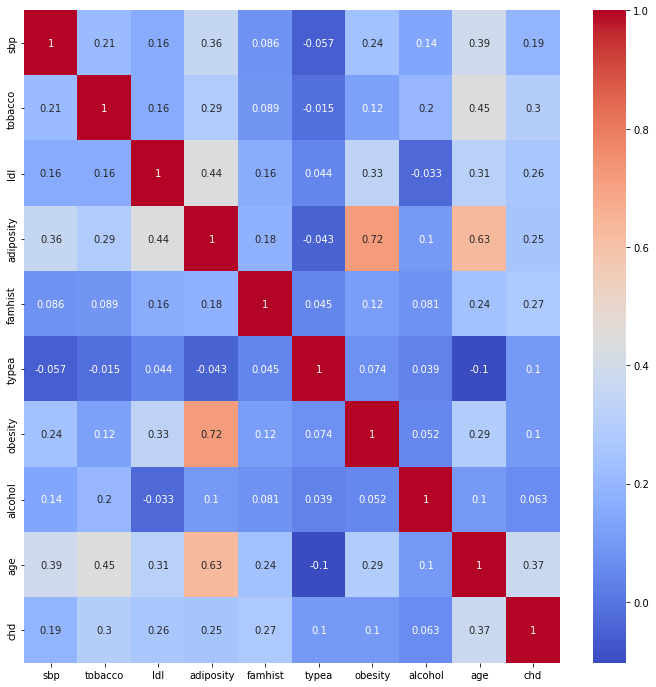

In [12]:
# plot a heatmap of all numeric data with annotation
corr = df.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,cmap='coolwarm')

---

There appear to be strong correlations between Age, Obesity, and Adiposity (fatty tissue in the body).  Not as high but decent correlations between tobacco use and Age, as well as Adiposity and LDL (cholesterol).

---


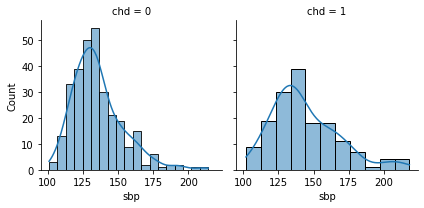

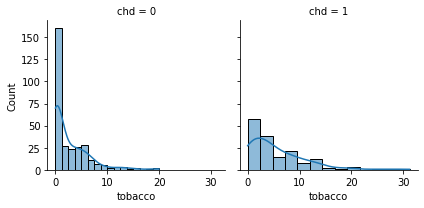

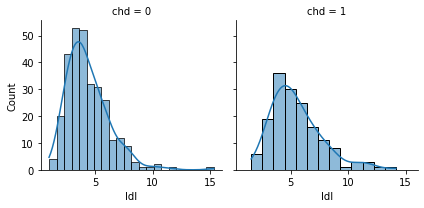

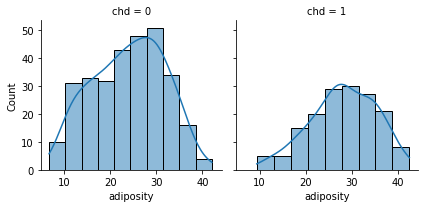

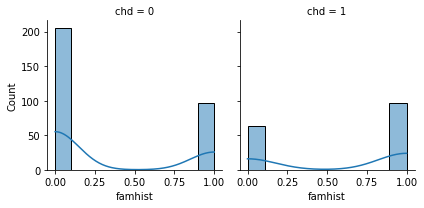

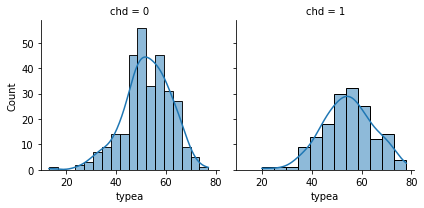

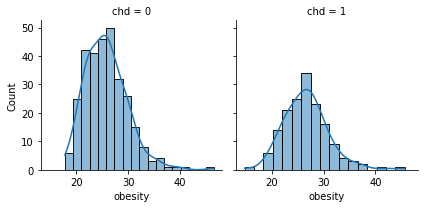

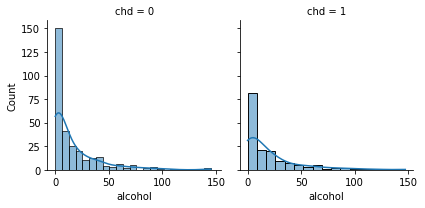

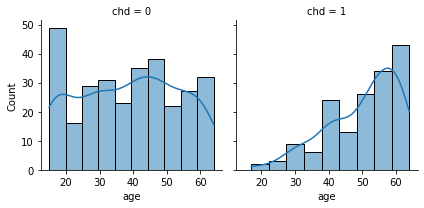

In [13]:
# I found a visualization called FacetGrid that allows me to compare
# a one feature against the others in a meaningful way

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="sbp", kde=True)
  
fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="tobacco", kde=True)

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="ldl", kde=True)
  
fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="adiposity", kde=True)

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="famhist", kde=True)
  
fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="typea", kde=True)

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="obesity", kde=True)
  
fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="alcohol", kde=True)

fig = sns.FacetGrid(df, col="chd")
fig.map_dataframe(sns.histplot, x="age", kde=True)
  

---

The chart above is a histogram showing the diagnosis of Coronary Heart Disease (CHD 0 is negative, CHD 1 is positive) against each feature in the dataframe
which allows me to directly compare each feature.

---

## MODELING AND PROCESSING

In [14]:
X = df.drop(columns = 'chd')
y = df['chd']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
scaled_df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
scaled_df


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,0.478412,-0.295503,1.185854,-0.418470,-0.176786,3.277738,0.629336,1.373863
1,0.277089,-0.790237,-0.159680,0.412140,-0.843274,0.193344,0.671373,-0.612745,1.383115,1.373863
2,-0.992806,-0.774980,-0.609245,0.884332,1.185854,-0.112563,0.735519,-0.541183,0.218184,-0.727875
3,1.546985,0.842264,0.807126,1.624141,1.185854,-0.214532,1.412621,0.295062,1.040488,1.373863
4,-0.211332,2.171805,-0.599577,0.305351,1.185854,0.703189,-0.012856,1.647775,0.423760,1.373863
...,...,...,...,...,...,...,...,...,...,...
457,3.696039,-0.705234,0.599263,0.812281,-0.843274,1.111065,0.571590,-0.696983,1.040488,-0.727875
458,2.133091,0.123004,-0.159680,0.861173,-0.843274,-0.112563,0.609602,0.068519,0.629336,1.373863
459,-1.481228,-0.138545,-1.522877,-1.309364,-0.843274,-1.336191,-1.414575,0.392385,0.834912,-0.727875
460,-0.992806,0.384553,3.320823,0.692625,-0.843274,1.111065,0.310252,0.283203,-0.192969,-0.727875


In [20]:
# Pre-Process for Machine Learning with a pipeline
# This will identify all of the quantitative features (columns)
quant_feat = make_column_selector(dtype_include = 'number')

# Scale the data to be ready for clustering (KNN)
scaler = StandardScaler()

#We will use a mean imputer to impute values missing for the numeric columns
mean_imputer = SimpleImputer(strategy='mean')

# We will use a most frequent imputer to impute values for the categorical columns
freq_imputer = SimpleImputer(strategy='most_frequent')

In [21]:
num_processor = make_pipeline(mean_imputer, scaler)
#cat_processor = make_pipeline(freq_imputer, encoder)

In [22]:
num_tuple = (num_processor, quant_feat)
#cat_tuple = (cat_processor, cat_feat)

In [23]:
# Now make the column transformer...this matches the transformations that we want with the appropriate columns.
column_transformer = make_column_transformer(num_tuple, remainder='passthrough')

## KNN

In [24]:
# Try a default KNN model in the pipeline 
# Instantiate the model
knn = KNeighborsClassifier(n_neighbors=7)

# Make the pipeline...notice we included the column_transformer here
knn_pipe = make_pipeline(column_transformer, knn)

# Fit on training data only
knn_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f708a460390>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

In [25]:
knn_predict = knn_pipe.predict(X_test)
knn_predict

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0])

In [26]:
train_preds = knn_pipe.predict(X_train)
test_preds = knn_pipe.predict(X_test)

print('KNN Training accuracy:', accuracy_score(y_train, train_preds))
print('KNN Testing accuracy:', accuracy_score(y_test, test_preds))

KNN Training accuracy: 0.7572254335260116
KNN Testing accuracy: 0.6982758620689655


In [27]:
# Hypertune the KNN model
# The following code gives a list of hyperparameters to tune and how to define them within a pipeline using the model name and __

knn_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f708a460390>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 'columntransformer__pipeline__memory': None,
 'columntransformer__pipeline__simpleimputer': SimpleImputer(),
 'columntransformer__pipeline__simpleimputer__add_indicator': False,
 'columntransformer__pipeline__simpleimputer__copy': True,
 'columntransformer__pipeline__simpleimputer__fill_value': None,
 'columnt

In [28]:
# Define the hyperparameters you want to test.
knn_params = {'kneighborsclassifier__n_neighbors' : range(1, 20),
              'kneighborsclassifier__leaf_size' : [5, 10, 15],
              'kneighborsclassifier__weights': ['uniform', 'distance'],
              'kneighborsclassifier__p': [4, 5, 6]}

In [29]:
# Instantiate the Gridsearch with the KNN pipeline and the knn_params 
knn_grid = GridSearchCV(knn_pipe, knn_params)

knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f708a460390>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=7))]),
             param_grid={'kneighborsclassifier__leaf_size': [5, 10, 15],
                         'kneighborsclassifier__n_neighbors': range(1, 20),
                         'kneighborsclassifier__p': [4, 5, 6],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [30]:
# Check the optimal combinations of hyperparameters
knn_grid.best_params_

{'kneighborsclassifier__leaf_size': 5,
 'kneighborsclassifier__n_neighbors': 13,
 'kneighborsclassifier__p': 5,
 'kneighborsclassifier__weights': 'uniform'}

In [31]:
# extract the best version of the model from the gridsearch object
best_knn = knn_grid.best_estimator_

In [32]:
# Run a classification report on both train and test datasets for the best model. 
# How is your model doing?  Did the performance improve? How is the overfitting?
train_preds = best_knn.predict(X_train)
test_preds = best_knn.predict(X_test)

print('Best Model Training Metrics')
print(classification_report(y_train, train_preds))
print('\nBest Model Testing Metrics')
print(classification_report(y_test, test_preds))

Best Model Training Metrics
              precision    recall  f1-score   support

           0       0.75      0.92      0.82       227
           1       0.73      0.40      0.52       119

    accuracy                           0.74       346
   macro avg       0.74      0.66      0.67       346
weighted avg       0.74      0.74      0.72       346


Best Model Testing Metrics
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        75
           1       0.69      0.27      0.39        41

    accuracy                           0.70       116
   macro avg       0.69      0.60      0.59       116
weighted avg       0.70      0.70      0.65       116



## Random Forest

In [33]:
# We will use defaults here since our hyperturning will be done with GridSearchCV
rf = RandomForestClassifier(random_state = 42)

# Make the pipeline and include the column_transformer
rf_pipe = make_pipeline(column_transformer, rf)
# Fit only on training data!
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f708a460390>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [34]:
rf_predict=rf.predict(X_test)
rf_predict

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [35]:
rf_train_preds = rf_predict=rf.predict(X_train)
rf_test_preds = rf_predict=rf.predict(X_test)

print('Training accuracy:', accuracy_score(y_train, rf_train_preds))
print('Testing accuracy:', accuracy_score(y_test, rf_test_preds))

Training accuracy: 0.3439306358381503
Testing accuracy: 0.35344827586206895


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [36]:
# Now we will hypertune the random forest model.
# To see the hyperparamters available and to remember how to define them within a pipeline, use the following
rf_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f708a460390>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 'columntransformer__pipeline__memory': None,
 'columntransformer__pipeline__simpleimputer': SimpleImputer(),
 'columntransformer__pipeline__simpleimputer__add_indicator': False,
 'columntransformer__pipeline__simpleimputer__copy': True,
 'columntransformer__pipeline__simpleimputer__fill_value': None,
 'columnt

In [37]:
# Define the hyperparameters you want to test.
rf_params = {'randomforestclassifier__max_depth' : range(2, 3),
             'randomforestclassifier__n_estimators' : [195, 198],
             'randomforestclassifier__min_samples_split' : [2,3]}

In [38]:
# Instantiate the Gridsearch with the Random Forest pipeline
best_rf = GridSearchCV(rf_pipe, rf_params)

best_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f708a460390>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': range(2, 3),
                         'randomforestclassifier__min_samples_split': [2, 3],
                         'randomforestclassifier__n_estimators': [195, 198]})

In [39]:
# See which hyperparameters gave the best results
best_rf.best_params_

{'randomforestclassifier__max_depth': 2,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 195}

In [40]:
# Run a classification report on both train and test datasets for the best model. 
# How is your model doing?  Did the performance improve? How is the overfitting?
rf_train_preds = best_rf.predict(X_train)
rf_test_preds = best_rf.predict(X_test)

print('Best Model Training Metrics')
print(classification_report(y_train, rf_train_preds))
print('\nBest Model Testing Metrics')
print(classification_report(y_test, rf_test_preds))

Best Model Training Metrics
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       227
           1       0.82      0.35      0.49       119

    accuracy                           0.75       346
   macro avg       0.78      0.66      0.66       346
weighted avg       0.77      0.75      0.72       346


Best Model Testing Metrics
              precision    recall  f1-score   support

           0       0.70      0.85      0.77        75
           1       0.54      0.32      0.40        41

    accuracy                           0.66       116
   macro avg       0.62      0.59      0.58       116
weighted avg       0.64      0.66      0.64       116



## Clustering

In [41]:
def plot_k_values(data, ks):
  """plot the silhouette score and inertia 
  of a KMeans model for various k values"""

  sils = []
  inertias = []

  for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sils.append(silhouette_score(data, km.labels_))
    inertias.append(km.inertia_)
      
    # plot inertia and silhouette score
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.set_xlabel('number of clusters')
  ax1.set_ylabel('Inertia', color = 'blue')
  ax1.plot(ks, inertias, color = 'blue',label='inertia',marker ='o')

  ax2 = ax1.twinx()
  
  ax2.set_ylabel('Silhouette Score', color = 'red')
  ax2.plot(ks, sils, color = 'red',label='silhouette score',marker='+')
  ax1.legend(loc=0)  
  ax2.legend(loc='upper left')
  plt.grid()
  plt.show()

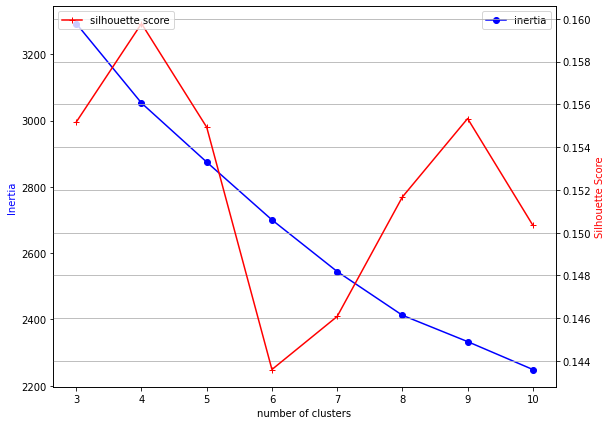

In [42]:
plot_k_values(scaled_df,range(3,11))

In [43]:
# Fit kmeans model with 2 clusters and display the silhouette score
kmeans = KMeans(n_clusters = 4)
kmeans.fit(scaled_df)
silhouette_score(scaled_df, kmeans.labels_)

0.15993816742284492

In [44]:
df["cluster"]=kmeans.labels_

In [45]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).median()
cluster_groups

,cluster,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,0,142.0,6.00,4.01,27.78,1.0,54.0,26.09,66.27,48.0,0.0
1,1,128.0,0.12,3.30,17.16,0.0,55.0,22.59,2.49,27.0,0.0
2,2,140.0,4.00,5.58,29.54,1.0,55.0,27.19,6.04,54.0,1.0
3,3,136.0,2.55,4.89,29.63,0.0,52.0,27.62,8.33,48.0,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

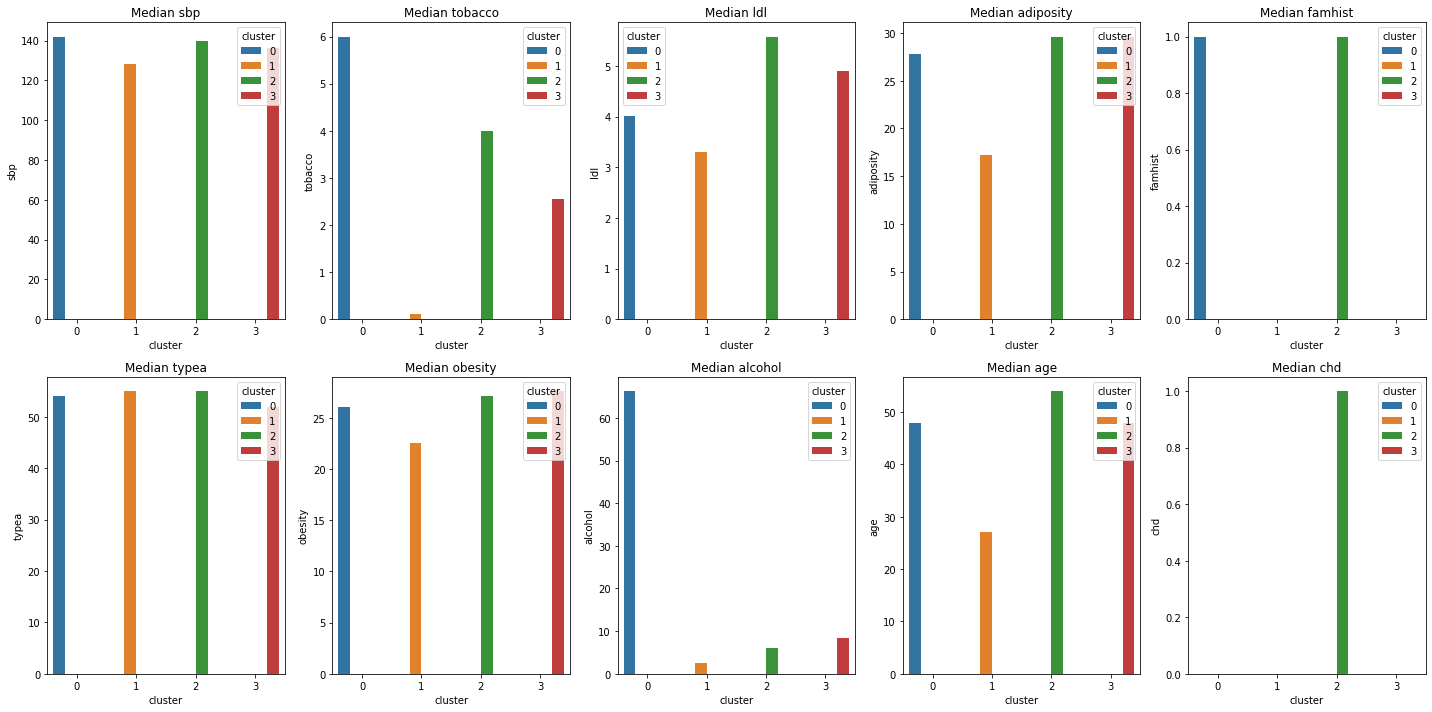

In [46]:
# Visualize medians 
fig, axes = plt.subplots(2,5, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  #axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  sns.barplot(cluster_groups['cluster'], cluster_groups[col], hue=cluster_groups['cluster'], ax=axes[i])
  #sns.scatterplot(data=df, x=col, y='price', hue='cluster', ax=axes[i])
  axes[i].set_title(f'Median {col}')
plt.tight_layout()